<a href="https://colab.research.google.com/github/mkorlyakova/vae/blob/main/%D0%A1IFAR_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoder

**Author:** [MKorlyakova](https://github.com/mkorlyakova/vae.git)<br>
**Date created:** 2020/12/19<br>
**Last modified:** 2020/12/19<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on CIFAR.

## Setup


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Строим слой семплирования sampling layer


In [3]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



## Строим энкодер encoder


In [147]:


def my_encoder(image_size = 28, chanels = 1, latent_dim = 2, layers_kernel = [128,256], dense_kernel =128, activation_ = "relu"):
  '''
  сверточный энкодер
  image_size = 28  - размер по стороне у картинки,
  chanels = 1 - число каналов цвета, 
  latent_dim = 2 - размерность скрытого пространства,
  layers_kernel = [128,256] - список числа ядер для сверточных слоев (аналогичный на декодере) - заодно знаем сколько сверток, 
  dense_kernel =128 - число нейронов полносвязного слоя , 
  activation_ = "relu" - активация всех слоев

  вернем - энкодер как модель
  '''
  encoder_inputs = keras.Input(shape=(image_size, image_size, chanels))
  x = layers.Conv2D(layers_kernel[0], 3, activation=activation_ , strides=2, padding="same")(encoder_inputs)
  for i in layers_kernel[1:]:
    x = layers.Conv2D(i, 3, activation=activation_ , strides=2, padding="same")(x)  # шаг свертки 2 - поэтому без пулинга
  x = layers.Flatten()(x)
  x = layers.Dense(dense_kernel, activation=activation_ )(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
  encoder.summary()
  return encoder


## Строим свой decoder


In [148]:
def my_decoder(image_size = 28, chanels = 1, latent_dim = 8, layers_kernel = [128,256], dense_kernel =512, activation_ = "relu"):
    '''
  сверточный декодер
  image_size = 28  - размер по стороне у картинки,
  chanels = 1 - число каналов цвета, 
  latent_dim = 2 - размерность скрытого пространства,
  layers_kernel = [128,256] - список числа ядер для сверточных слоев (аналогичный на энкодере) - заодно знаем сколько сверток, 
  dense_kernel =128 - число нейронов полносвязного слоя , 
  activation_ = "relu" - активация всех слоев

  вернем - декодер как модель
  '''
  latent_inputs = keras.Input(shape=(latent_dim,))
  layers_kernel_ = layers_kernel.copy()
  layers_kernel_.reverse()
  dense_kernel_numb = (image_size // (2**len(layers_kernel))) 
  dense_kernel_ = dense_kernel_numb** 2 * dense_kernel  # 7 * 7 * 64
  x = layers.Dense(dense_kernel_, activation=activation_)(latent_inputs)
  x = layers.Reshape((dense_kernel_numb, dense_kernel_numb, dense_kernel))(x)
  for i in layers_kernel_:
    x = layers.Conv2DTranspose(i, 3, activation=activation_, strides=2, padding="same")(x)

  decoder_outputs = layers.Conv2DTranspose(chanels, 3, activation="sigmoid", padding="same")(x)
  decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
  decoder.summary()
  return decoder


CIFAR большая задача - можно попробовать большее пространство, и большие модели

In [149]:
encoder = my_encoder(image_size = 32, chanels = 3, latent_dim = 8, layers_kernel = [64,128,256], dense_kernel =512, activation_ = "relu")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 16, 16, 64)   1792        input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 8, 8, 128)    73856       conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 4, 4, 256)    295168      conv2d_10[0][0]                  
____________________________________________________________________________________________

In [151]:
decoder = my_decoder(image_size = 32, chanels = 3, latent_dim = 8, layers_kernel = [64,128,256], dense_kernel =512, activation_ = "relu")

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 8)]               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8192)              73728     
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 8, 8, 256)         1179904   
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 32, 32, 64)        73792     
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 32, 32, 3)         1731

## Создаем класс модель по `Model` с особым шагом *обучения* `train_step`


In [152]:

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder,image_size, chanels, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.image_size = image_size 
        self.chanels = chanels

    def train_step(self, data):
        '''
        метод для тренировки VAE
        '''
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= self.image_size  * self.image_size * self.chanels
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    def call(self, inputs, training=False):
      '''
      понадобился перекрытый метод для прямого прохода, т.к. в декодер предаем молько 1 выход энкодера
      '''
      z_mean, z_log_var, z = self.encoder(inputs)  
      return self.decoder(z)


## Учим VAE


In [140]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# можно попробовать учить на одном классе
#label = 0
#x_train=x_train[np.where((y_train == label))[0],:,:,:]
#x_test=x_test[np.where((y_test == label))[0],:,:,:]

data_cifar10 = np.concatenate([x_train, x_test], axis=0)
data_cifar10 = data_cifar10.astype("float32") / 255

Пример объектов CIFAR10

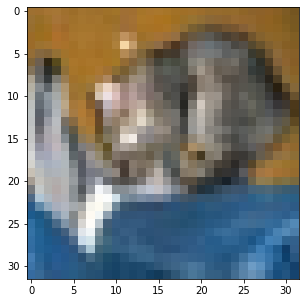

In [141]:
from PIL import Image
import matplotlib.pyplot as plt

classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

plt.figure(figsize=(5,5))
plt.imshow(Image.fromarray(x_test[0,:,:,:]))
plt.show()

Создадим объект для обратного вызова по качеству реконструкции (можно и по KL)

In [153]:
el_stop = tf.keras.callbacks.EarlyStopping(monitor='reconstruction_loss',patience=5)

Создаем и учим модель

In [154]:


vae = VAE(encoder, decoder,32,3)
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(data_cifar10, epochs=15, batch_size=128,  callbacks=[el_stop])


Epoch 1/15
469/469 [==============================] - 14s 29ms/step - loss: 1912.3257 - reconstruction_loss: 1909.4191 - kl_loss: 2.9066
Epoch 2/15
469/469 [==============================] - 14s 29ms/step - loss: 1858.8881 - reconstruction_loss: 1855.7405 - kl_loss: 3.1476
Epoch 3/15
469/469 [==============================] - 14s 30ms/step - loss: 1854.9966 - reconstruction_loss: 1851.8524 - kl_loss: 3.1442
Epoch 4/15
469/469 [==============================] - 14s 30ms/step - loss: 1853.4536 - reconstruction_loss: 1850.3052 - kl_loss: 3.1484
Epoch 5/15
469/469 [==============================] - 14s 30ms/step - loss: 1852.0809 - reconstruction_loss: 1848.9314 - kl_loss: 3.1496
Epoch 6/15
469/469 [==============================] - 14s 29ms/step - loss: 1850.6237 - reconstruction_loss: 1847.4671 - kl_loss: 3.1566
Epoch 7/15
469/469 [==============================] - 14s 29ms/step - loss: 1849.8704 - reconstruction_loss: 1846.7070 - kl_loss: 3.1634
Epoch 8/15
469/469 [=====================

Можно построить аугментацию через ImageDataGenerator

In [166]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=10, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

In [167]:
datagen.fit(data_cifar10)

Поучим с ImageDataGenerator

In [168]:
vae.fit(datagen.flow(data_cifar10, batch_size=5), epochs=5, batch_size=64 , callbacks=[el_stop])
#vae.fit(data_cifar10, epochs=150, batch_size=64, callbacks=[el_stop])

Epoch 1/5
12000/12000 [==============================] - 79s 7ms/step - loss: 1850.7198 - reconstruction_loss: 1847.5489 - kl_loss: 3.1709
Epoch 2/5
12000/12000 [==============================] - 80s 7ms/step - loss: 1850.2172 - reconstruction_loss: 1847.0413 - kl_loss: 3.1760
Epoch 3/5
12000/12000 [==============================] - 81s 7ms/step - loss: 1849.8250 - reconstruction_loss: 1846.6369 - kl_loss: 3.1881
Epoch 4/5
12000/12000 [==============================] - 81s 7ms/step - loss: 1849.9321 - reconstruction_loss: 1846.7473 - kl_loss: 3.1849
Epoch 5/5
12000/12000 [==============================] - 82s 7ms/step - loss: 1849.4506 - reconstruction_loss: 1846.2605 - kl_loss: 3.1901


Можно изменить параметры обучения - тут меняем скорость обучения , но пожно поменять все: оптимизатор, метрики, лосы ...

In [174]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001))
vae.fit(data_cifar10, epochs=150, batch_size=16, callbacks=[el_stop])

Epoch 1/150
3750/3750 [==============================] - 24s 6ms/step - loss: 1848.5944 - reconstruction_loss: 1845.4058 - kl_loss: 3.1886
Epoch 2/150
3750/3750 [==============================] - 24s 6ms/step - loss: 1847.8414 - reconstruction_loss: 1844.6402 - kl_loss: 3.2013
Epoch 3/150
3750/3750 [==============================] - 24s 6ms/step - loss: 1847.5093 - reconstruction_loss: 1844.3015 - kl_loss: 3.2078
Epoch 4/150
3750/3750 [==============================] - 24s 6ms/step - loss: 1847.2733 - reconstruction_loss: 1844.0630 - kl_loss: 3.2103
Epoch 5/150
3750/3750 [==============================] - 24s 6ms/step - loss: 1847.1000 - reconstruction_loss: 1843.8863 - kl_loss: 3.2137
Epoch 6/150
3750/3750 [==============================] - 24s 7ms/step - loss: 1846.9587 - reconstruction_loss: 1843.7490 - kl_loss: 3.2097


## Результат предсказания для CIFAR10 (класс 0)


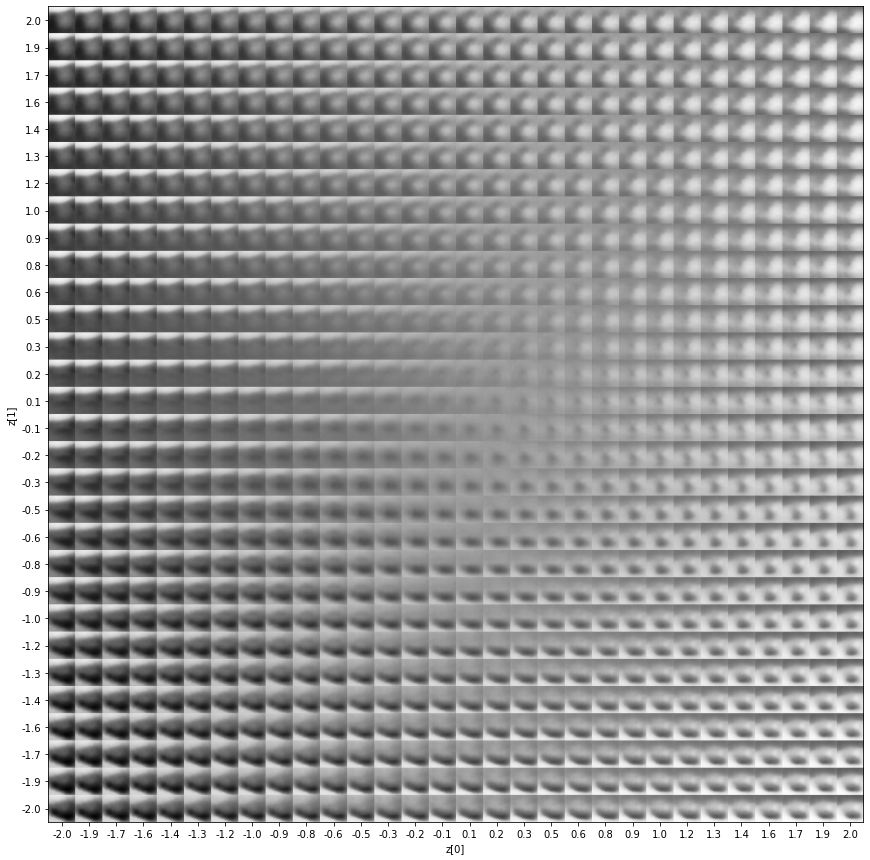

In [175]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder,image_size,chanels, latent_dim=2):
    # display a n*n 2D manifold of digits
    n = 30
    imag_size = image_size
    scale = 2.0
    figsize = 15
    figure = np.zeros((imag_size * n, imag_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            latent_vect = np.zeros((1,latent_dim))
            latent_vect[0,0]=xi
            latent_vect[0,1]=yi
            z_sample = np.array(latent_vect)
            x_decoded = decoder.predict(z_sample)
            image_ = x_decoded[0].reshape(imag_size, imag_size,chanels).mean(axis=2)
            figure[
                i * imag_size : (i + 1) * imag_size,
                j * imag_size : (j + 1) * imag_size
            ] = image_

    plt.figure(figsize=(figsize, figsize))
    start_range = imag_size // 2
    end_range = n * imag_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, imag_size,)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder,32,3,8)


## Посмотрим на кластеры в скрытом пространстве для CIFAR


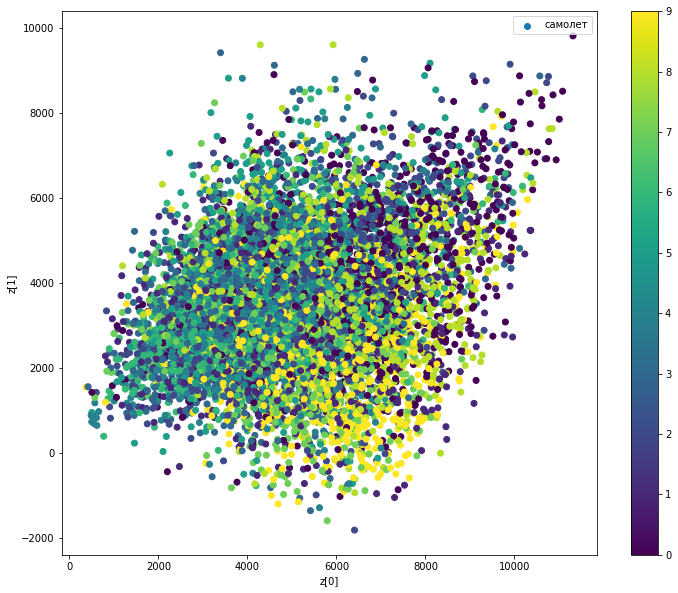

In [183]:

def plot_label_clusters(encoder, data,label):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:,7], z_mean[:, 0], c = label)
    plt.colorbar()
    plt.legend(classes)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


plot_label_clusters(encoder, x_test, y_test)


Построим немного примеров генерации объектов:

для этого не нужен энкодер
работа этой модели требует:
- выбрать случайные значения для точки скрытого пространства (2 координаты (среднее и логарифм от дисперсиии) - для построения в n (в нашем случае 32х32Х3) координаты нового образца )
- подать их в декодер
- визуализировать результат

In [184]:


def plot_digit_from_decoder(decoder, z, digit_size):
    # display a 2D plot of the digit classes in the latent space
    
    data = np.array([z])
    print(data.shape)
    digit = decoder.predict(data)
    digit_ = digit[0].reshape(digit_size, digit_size,3)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(digit_/np.max(digit_))
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()





(1, 8)


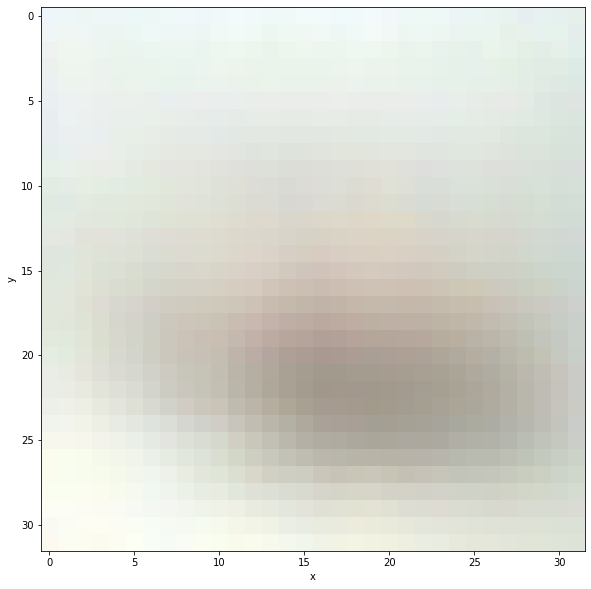

In [185]:
plot_digit_from_decoder(decoder, [-.2,-.60,0,0,0,0,0,0], 32)